<a href="https://colab.research.google.com/github/6daniel32/RedConvolutiva/blob/master/RedConvolutiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocedor de lengua de signos

Vamos a desarrollar una red que reconozca lengua de signos. Para ello, vamos a utilizar un dataset contenido en nuestra cuenta de Google Drive. Antes, debemos montar nuestro sistema de archivos de Google Drive para hacerlo accesible desde este *notebook*. Google nos solicitará permiso, tenemos que copiar y pegar el código que nos suministra.

El dataset está en la página de cayetano. Es más eficiente tenerlo en google (ya que colab tambien esta en google), descomprimiendolo dentro de una carpeta en nuestro drive e indiciandole al python donde esta la carpeta.

Para poder solucionar el problema de la verificación hay que usar el enlace de abajo para dar permisos a google.

Nos da este codigo de autorizacion que debemos incluir en el programa de la red: 4/PgF3jQzaRUfIWY8DHrR-heG9dzoyWaI0NVyoe2yX6FkqqG7xbw9OoxM (probablemente haya que sacarlo de nuevo)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Ahora ya es accesible

¿Estoy realmente utilizando una GPU? Compruébalo en **Editar / Configuración del cuaderno** o **Entorno de ejecuación / Cambiar tipo de entorno de ejecución**

In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets" #esto hace un ls en la carpeta que dice
from matplotlib.pyplot import imshow #matplotlib = libreria grafica de python
import numpy as np
from PIL import Image

%matplotlib inline # el "%" implica que la imagen no se abrira en una ventana aparte si no como algo incrustable en el documento web.
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Sign-Language/4/IMG_1132.JPG', 'r')
imshow(np.asarray(pil_im))



ls: cannot access '/content/drive/My Drive/Colab Notebooks/datasets': No such file or directory


UsageError: unrecognized arguments: # el "%" implica que la imagen no se abrira en una ventana aparte si no como algo incrustable en el documento web.


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Primer modelo

In [0]:
from keras.preprocessing.image import ImageDataGenerator #fuente de datos
from keras.models import Sequential #modelo
from keras.layers import Dense, Dropout #entrenamiento
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras
from time import time


# DATA SOURCE --------------------------------------------------

batch_size = 20

train_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/Sign-Language' #definimos dos directorios, uno para training y otro para validación, aquí los dos directorios van al             
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/Sign-Language' #mismo sitio pero esto no debería ser así, debería haber una carpeta para cada cosa.

#en inteligencia artificial cuanto más datos mejor, con imágenes no pasa lo contrario (ejemplo con imagen de un pájaro). Una forma de crear más imágenes artificialmente 
#para entrenar mejor es darle la vuelta a las imágenes horizontalmente, porque un pájaro mirando a la izquierda y un pájaro mirando a la derecha también es un pájaro, 
#hacer un pequeño zoom, porque un pájaro de cerca y de lejos también es un pájaro, rotar un poquito la imagen sobre el eje central o una combinación de todo esto.

train_datagen = ImageDataGenerator( #este código hace lo del párrafo de arriba.
        rescale=1./255, #esto solo es para convertir valores entre 0 y 1.
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) #aqui solo convertimos valores entre 0 y 1.

train_generator = train_datagen.flow_from_directory( #escala las imagenes todas al mismo tamaño porque para la red tienen que tener un formato estándar.
        train_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #lo mismo que arriba
        validation_data_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# MODEL --------------------------------------------------

#aqui el modelo se construye de manera funcional. Mirar esto (https://nbviewer.jupyter.org/url/cayetanoguerra.github.io/spegc/DeepLearning/Day2/04-Arquitecturas.ipynb)
#las capas pasan de ser una estructura que va una detras de otra (Sequential) a ser una funcion con valores de entrada y salida que pueden seguir el orden que quieran

#Parámetros en una red: los pesos (los parámetros de la red que la red pone por aprendizaje)
#Hiperparámetros: parámetros de la red que no aprende, que los ponemos nosotros por experiencia y por reglas heurísticas de la IA.

#Explicación del filtro: al entrar en la primera capa de la red convolutiva hay 32 kernel, el primer kernel tiene 148x148 (capa entrada creo). Luego formamos neuronas que forman el
#primer filtro, cada una de 27 entradas (bloques de (3x3 pixeles)x3 canales rgb). La siguiente neurona coge un bloque que tiene los mismos pixeles salvo los 3 primero que sustituye por
#los 3 siguientes. A la primera capa de filtros se aplican más filtros y asi sucesivamente. La sifuiente capa a filtrar será de 148x148x32 slices de profundidad (32 hiperparámetro).

#Explicación MaxPooling: dividimos cada slice del output del filtro anterior en submatrices de 2x2. De cada submatriz sacamos un píxel con el valor más representativo que hay en ella. 
#Al final tenemos una capa de (74x74x32), reducimos la matriz a la mitad.

#Ahora, despues del MaxPooling volvemos a aplicar otro filtro de 3x3 pero con x32 de profundidad (se va alargando el dataset de aplicarle filtros, empezamos 
#con profundidad de 3 por los canales rgb y ya estamos en profundidad de 32). Tenemos 64 en la salida de esta capa (el 64 es un hiperparámetro). El tensor de salida será
#de 72x72x64 después de aplicar este filtro.

#Despues de la aplicacion del segundo filtro, se vuelve a aplicar un Maxpooling, que vuelve a dividir entre dos el tamaño de las imágenes, quedando una capa de 36x36x64.

#El Dropout lo dejamos de momento, no tiene efecto en el modelo

#Flatten: las "capas convolutivas" están hechas para procesar datos en 2D pero las redes full connected solo soportan vectores. Esta funcion convierte lo anterior de 36x25x64 en un vector
#lineal de 82944 elementos (linealizamos la matriz).

#Despues del Flatten, encontramos una capa oculta de 128 neuronas (hiperparámetro), que tiene como entrada los 82944 elementos del vector (pesos=82944*128)

#El Dropout se explica mas adelante

#Lo ultimo es la capa de salida de la neurona, va con softmax para que la distribucion de probabilidad sume 1

#Explicacion dropout: es una herramienta que hace que los outliers no te revienten mucho el modelo. Un Dropout del 50% implica que la mitad de las neuronas de un capa se congelen 
#en unos cuantos pasos de entrenamiento y se actualicen solo los pesos de las otras, despues de unos cuantos pasos se congelarán otras neuronas aleatoriamente durante unos cuantos pasos 
#(el 50% otra vez). Congelar significa que actuan pero sus pesos no se actualizan.

model = Sequential() 
model.add(Conv2D(32, kernel_size=(3, 3), #32 filtros de 3x3 
                 activation='relu',  #otra funcion de activacion distinta del sigmoide
                 input_shape=(150, 150, 3))) #tamaño de imagen y rgb=3 para que la imagen sea a color
model.add(MaxPooling2D(pool_size=(2, 2))) #MaxPooling descarta los datos que aportan poco
model.add(Conv2D(64, (3, 3), activation='relu')) #otra capa sobre lo anterior
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, #funcion de loss (error) = categorical_crossentropy, una funcion de error como la de minimos cuadrados.
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy']) #accyraxy es lo que se acerca a la realidad el conjunto de validación.

# TRAINING --------------------------------------------------

#actualizacion de pesos

#fit generator se usa porque el conjunto de imágenes se ha conseguido con un generador y se han generado más imágenes artificialmente, entonces usamos fit generator en vez de fit.
#hay que hacer funcionar esto con estas imagenes y volver a hacer esto pero con un dataset de imágenes nuestro (podemos coger uno de cayetano en su pagina de Spegc). Hay que probar con 
#distintos hiperparámetros. Hay funciones que hacen que puedas poner un rango de hiperparametros, dejar esto ejecutando por la noche y por la mañana tienes una matriz de resultados.
#tenemos que conseguir un modelo que clasifique relativamente bien el dataset que vayamos a usar. La entrega será el código con el mejor resultado de entrenamiento. Si ponemos gráficas
#con comparaciones y demás, mejor. (he descargado el dataset de los barcos en el escritorio).

epochs = 10  

model.fit_generator(
        train_generator,
        steps_per_epoch=100, #pasos en cada entrenamiento
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=800,
)

#Parte que tenemos que hacer nosotros

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


dataset_LEGO  Iris_Mnist.ipynb	RedConvolutiva.ipynb


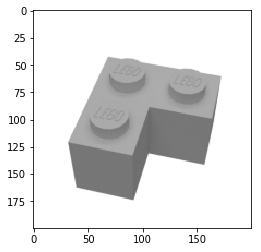

In [0]:
!ls "/content/gdrive/My Drive/Colab (inteligencia artificial)" #esto hace un ls en la carpeta que dice

import matplotlib.pyplot
from matplotlib.pyplot import imshow #matplotlib = libreria grafica de python
import numpy as np
from PIL import Image
                      #el "porcentaje" implica que la imagen no se abrira en una ventana aparte si no como algo incrustable en el documento web.
%matplotlib inline 
pil_im = Image.open('/content/gdrive/My Drive/Colab (inteligencia artificial)/dataset_LEGO/train/2357 Brick corner 1x2x2/201706171206-0001.png', 'r')
imshow(np.asarray(pil_im))



#Guardamos unas cuantas imágenes en validacion porque todas están en train (ejecutar solo una vez, luego comentar el código)

In [0]:
"""import os
directory1 = '/content/gdrive/My Drive/Colab (inteligencia artificial)/dataset_LEGO/train/'
directory2 = '/content/gdrive/My Drive/Colab (inteligencia artificial)/dataset_LEGO/valid/'
count=8

for directory3 in os.listdir(directory1):
  for image in os.listdir(directory1+directory3):
    count -= 1
    if (count == 0):
      count=8
      os.rename(directory1+directory3+'/'+image, directory2+directory3+'/'+image)"""
      

#Código para revertir lo anterior debajo de este texto por si hay fallos (comentar salvo necesidad de uso)

In [0]:
"""import os
directory1 = '/content/gdrive/My Drive/Colab (inteligencia artificial)/dataset_LEGO/train/'
directory2 = '/content/gdrive/My Drive/Colab (inteligencia artificial)/dataset_LEGO/valid/'


for directory3 in os.listdir(directory2):
  subdirectory=directory2+directory3
  for image in os.listdir(subdirectory):
      print(image)
      os.rename(subdirectory+'/'+image, directory1+directory3+'/'+image)"""

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Found 1830 images belonging to 6 classes.
Found 261 images belonging to 6 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 900s 9s/step - loss: 1.0319 - acc: 0.5780 - val_loss: 0.4016 - val_acc: 0.8314
Epoch 2/10
100/100 [==============================] - 71s 714ms/step - loss: 0.6654 - acc: 0.6960 - val_loss: 0.3550 - val_acc: 0.8736
Epoch 3/10
100/100 [==============================] - 70s 705ms/step - loss: 0.5506 - acc: 0.7330 - val_loss: 0.2957 - val_acc: 0.8696
Epoch 4/10
100/100 [==============================] - 68s 678ms/step - loss: 0.5206 - acc: 0.7465 - val_loss: 0.2950 - val_acc: 0.8622
Epoch 5/10
100/100 [==============================] - 69s 693ms/step - loss: 0.4819 - acc: 0.7830 - val_loss: 0.3063 - val_acc: 0.8427
Epoch 6/1

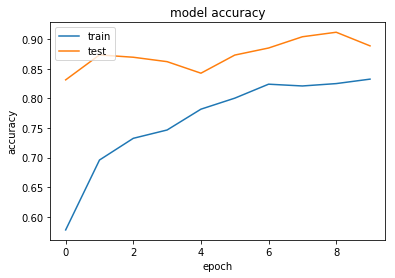

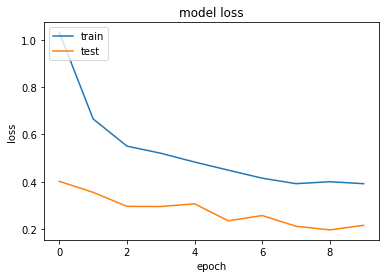

In [0]:
from keras.preprocessing.image import ImageDataGenerator #fuente de datos
from keras.models import Sequential #modelo
from keras.layers import Dense, Dropout #entrenamiento
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras
from time import time


# DATA SOURCE --------------------------------------------------

batch_size = 20

train_data_dir = '/content/gdrive/My Drive/Colab (inteligencia artificial)/dataset_LEGO/train' #definimos dos directorios, uno para training y otro para validación, aquí los dos directorios van al             
validation_data_dir = '/content/gdrive/My Drive/Colab (inteligencia artificial)/dataset_LEGO/valid' 

#en inteligencia artificial cuanto más datos mejor, con imágenes no pasa lo contrario (ejemplo con imagen de un pájaro). Una forma de crear más imágenes artificialmente 
#para entrenar mejor es darle la vuelta a las imágenes horizontalmente, porque un pájaro mirando a la izquierda y un pájaro mirando a la derecha también es un pájaro, 
#hacer un pequeño zoom, porque un pájaro de cerca y de lejos también es un pájaro, rotar un poquito la imagen sobre el eje central o una combinación de todo esto.

train_datagen = ImageDataGenerator( #este código hace lo del párrafo de arriba.
        rescale=1./255, #esto solo es para convertir valores entre 0 y 1.
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) #aqui solo convertimos valores entre 0 y 1.

train_generator = train_datagen.flow_from_directory( #escala las imagenes todas al mismo tamaño porque para la red tienen que tener un formato estándar.
        train_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #lo mismo que arriba
        validation_data_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# MODEL --------------------------------------------------

#aqui el modelo se construye de manera funcional. Mirar esto (https://nbviewer.jupyter.org/url/cayetanoguerra.github.io/spegc/DeepLearning/Day2/04-Arquitecturas.ipynb)
#las capas pasan de ser una estructura que va una detras de otra (Sequential) a ser una funcion con valores de entrada y salida que pueden seguir el orden que quieran

#Parámetros en una red: los pesos (los parámetros de la red que la red pone por aprendizaje)
#Hiperparámetros: parámetros de la red que no aprende, que los ponemos nosotros por experiencia y por reglas heurísticas de la IA.

#Explicación del filtro: al entrar en la primera capa de la red convolutiva hay 32 kernel, el primer kernel tiene 148x148 (capa entrada creo). Luego formamos neuronas que forman el
#primer filtro, cada una de 27 entradas (bloques de (3x3 pixeles)x3 canales rgb). La siguiente neurona coge un bloque que tiene los mismos pixeles salvo los 3 primero que sustituye por
#los 3 siguientes. A la primera capa de filtros se aplican más filtros y asi sucesivamente. La sifuiente capa a filtrar será de 148x148x32 slices de profundidad (32 hiperparámetro).

#Explicación MaxPooling: dividimos cada slice del output del filtro anterior en submatrices de 2x2. De cada submatriz sacamos un píxel con el valor más representativo que hay en ella. 
#Al final tenemos una capa de (74x74x32), reducimos la matriz a la mitad.

#Ahora, despues del MaxPooling volvemos a aplicar otro filtro de 3x3 pero con x32 de profundidad (se va alargando el dataset de aplicarle filtros, empezamos 
#con profundidad de 3 por los canales rgb y ya estamos en profundidad de 32). Tenemos 64 en la salida de esta capa (el 64 es un hiperparámetro). El tensor de salida será
#de 72x72x64 después de aplicar este filtro.

#Despues de la aplicacion del segundo filtro, se vuelve a aplicar un Maxpooling, que vuelve a dividir entre dos el tamaño de las imágenes, quedando una capa de 36x36x64.

#El Dropout lo dejamos de momento, no tiene efecto en el modelo

#Flatten: las "capas convolutivas" están hechas para procesar datos en 2D pero las redes full connected solo soportan vectores. Esta funcion convierte lo anterior de 36x25x64 en un vector
#lineal de 82944 elementos (linealizamos la matriz).

#Despues del Flatten, encontramos una capa oculta de 128 neuronas (hiperparámetro), que tiene como entrada los 82944 elementos del vector (pesos=82944*128)

#El Dropout se explica mas adelante

#Lo ultimo es la capa de salida de la neurona, va con softmax para que la distribucion de probabilidad sume 1

#Explicacion dropout: es una herramienta que hace que los outliers no te revienten mucho el modelo. Un Dropout del 50% implica que la mitad de las neuronas de un capa se congelen 
#en unos cuantos pasos de entrenamiento y se actualicen solo los pesos de las otras, despues de unos cuantos pasos se congelarán otras neuronas aleatoriamente durante unos cuantos pasos 
#(el 50% otra vez). Congelar significa que actuan pero sus pesos no se actualizan.

model = Sequential() 
model.add(Conv2D(32, kernel_size=(3, 3), #32 filtros de 3x3 
                 activation='relu',  #otra funcion de activacion distinta del sigmoide
                 input_shape=(150, 150, 3))) #tamaño de imagen y rgb=3 para que la imagen sea a color
model.add(MaxPooling2D(pool_size=(2, 2))) #MaxPooling descarta los datos que aportan poco
model.add(Conv2D(64, (3, 3), activation='relu')) #otra capa sobre lo anterior
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) #16 outputs

model.compile(loss=keras.losses.categorical_crossentropy, #funcion de loss (error) = categorical_crossentropy, una funcion de error como la de minimos cuadrados.
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy']) #accyraxy es lo que se acerca a la realidad el conjunto de validación.

# TRAINING --------------------------------------------------

#actualizacion de pesos

#fit generator se usa porque el conjunto de imágenes se ha conseguido con un generador y se han generado más imágenes artificialmente, entonces usamos fit generator en vez de fit.
#hay que hacer funcionar esto con estas imagenes y volver a hacer esto pero con un dataset de imágenes nuestro (podemos coger uno de cayetano en su pagina de Spegc). Hay que probar con 
#distintos hiperparámetros. Hay funciones que hacen que puedas poner un rango de hiperparametros, dejar esto ejecutando por la noche y por la mañana tienes una matriz de resultados.
#tenemos que conseguir un modelo que clasifique relativamente bien el dataset que vayamos a usar. La entrega será el código con el mejor resultado de entrenamiento. Si ponemos gráficas
#con comparaciones y demás, mejor. (he descargado el dataset de los barcos en el escritorio).

epochs = 10  

history = model.fit_generator(
        train_generator,
        steps_per_epoch=100, #pasos en cada entrenamiento
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=800,
)

print(history.history.keys())

matplotlib.pyplot.plot(history.history['acc'])
matplotlib.pyplot.plot(history.history['val_acc'])
matplotlib.pyplot.title('model accuracy')
matplotlib.pyplot.ylabel('accuracy')
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.legend(['train', 'test'], loc='upper left')
matplotlib.pyplot.show()

matplotlib.pyplot.plot(history.history['loss'])
matplotlib.pyplot.plot(history.history['val_loss'])
matplotlib.pyplot.title('model loss')
matplotlib.pyplot.ylabel('loss')
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.legend(['train', 'test'], loc='upper left')
matplotlib.pyplot.show()